In [ ]:
import pandas as pd
from google.colab import files
import io

# Upload (you've done this, but run once together with loading)
uploaded = files.upload()

# Use the exact uploaded filename shown in the output, or take the first key
filename = list(uploaded.keys())[0]

# Load Excel file to df
df = pd.read_excel(io.BytesIO(uploaded[filename]))

print("Dataset shape:", df.shape)
print("\nALL COLUMNS:")
print(df.columns.tolist())

print("\n" + "="*60)
print("DISTINCT VALUES FOR EACH COLUMN:")
print("="*60)

for col in df.columns:
    print(f"\n{col}:")
    unique_vals = df[col].unique()
    print(f"  Total unique: {len(unique_vals)}")
    print(f"  Values: {list(unique_vals)}")
    print("-" * 60)

print("\nDONE.")


Saving Peoples_Climate_Vote_Database_2024.xlsx to Peoples_Climate_Vote_Database_2024.xlsx
Dataset shape: (45784, 17)

ALL COLUMNS:
['Column1', 'ID', 'CID', 'QID', 'RID', 'EID', 'AID', 'Country', 'Question Text', 'Question Text (Short)', 'Response', 'Education', 'Age', 'Weighted Mean', 'Cat ID', 'Category', 'Question Context']

DISTINCT VALUES FOR EACH COLUMN:

Column1:
  Total unique: 45784
  Values: [np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(273), np.int64(274), np.int64(275), np.int64(276), np.int64(344), np.int64(345), np.int64(346), np.int64(347), np.int64(415), np.int64(416), np.int64(417), np.int64(418), np.int64(486), np.int64(487), np.int64(488), np.int64(489), np.int64(557), np.int64(558), np.int64(559), np.int64(560), np.int64(628), np.int64(629), np.int64(630), np.int64(631), np.int64(699), np.int64(700), np.int64(701), np.int64(702), np.int64(770), np.int64(771), np.int64(772), np.int64(773), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.


=== Logistic Regression ===
Accuracy: 0.6336779911373708
F1 Score: 0.38308457711442784
Balanced Accuracy: 0.7551292861157954
ROC-AUC: 0.7176483578254236


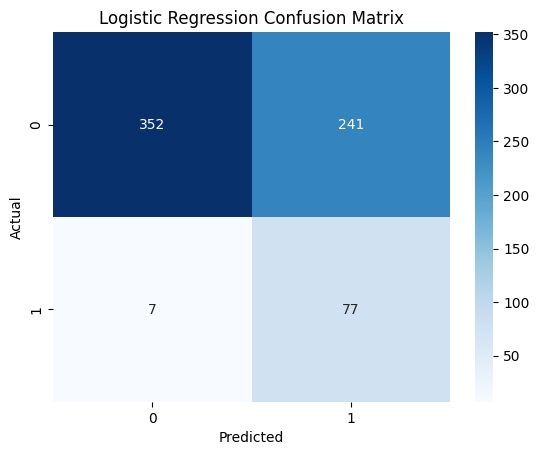

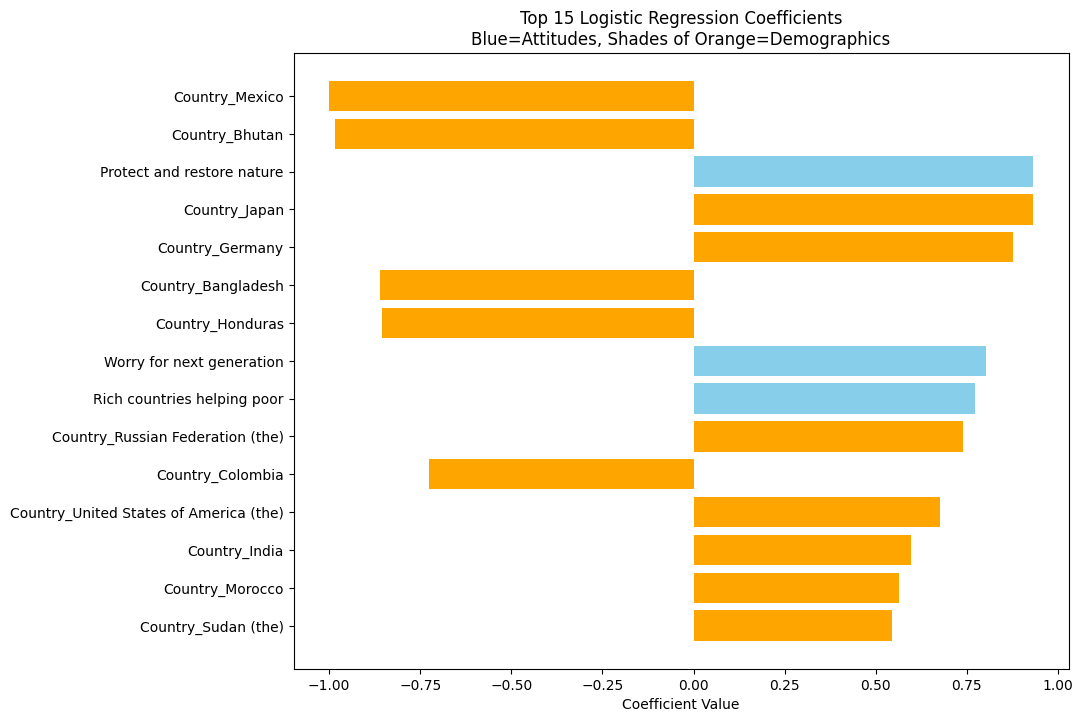


=== Random Forest ===
Best Threshold: 0.10
Accuracy: 0.5982274741506647
F1 Score: 0.09933774834437085
Balanced Accuracy: 0.4181221392435558
ROC-AUC: 0.6197301854974705


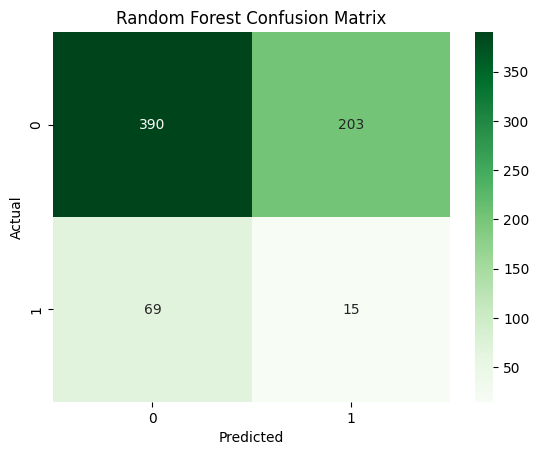

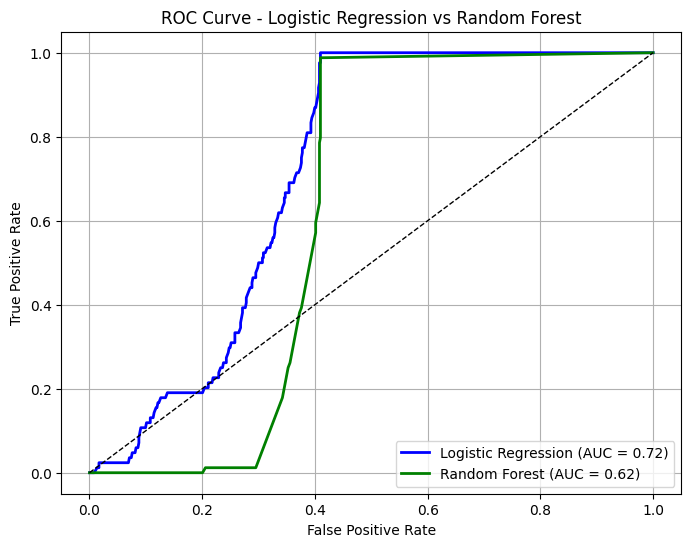

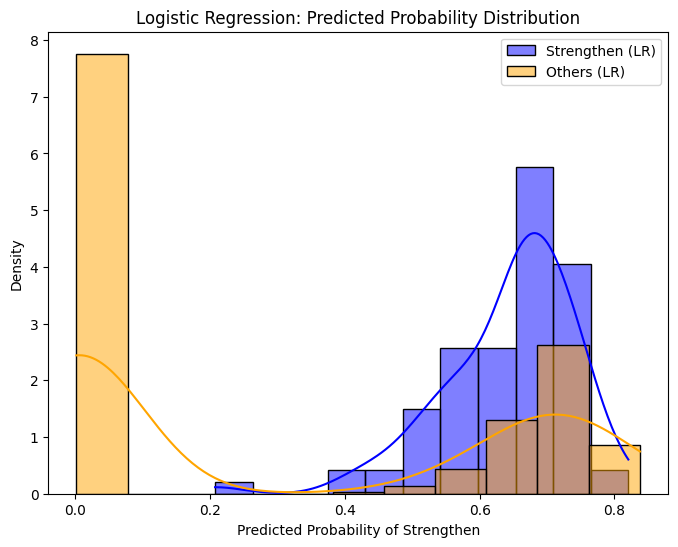

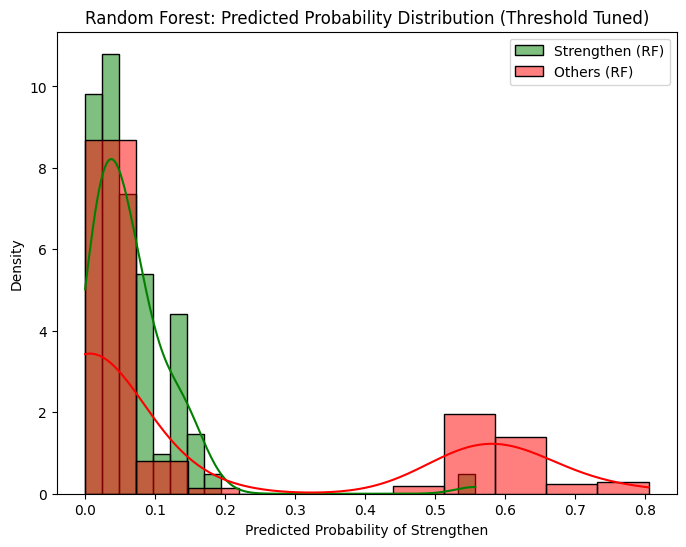

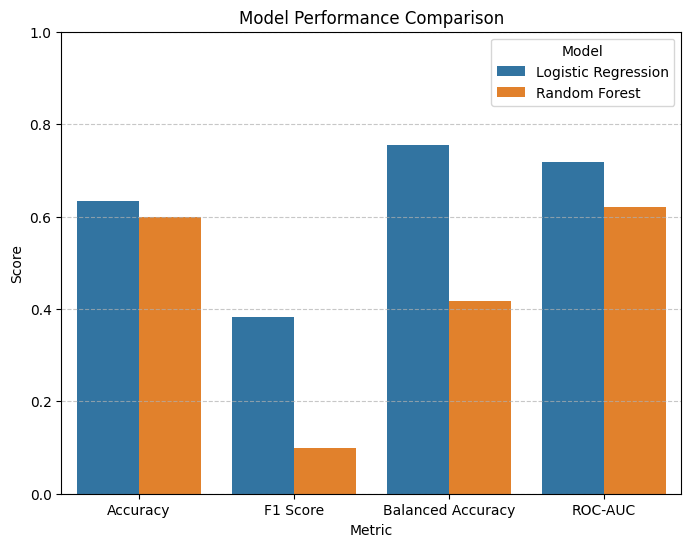

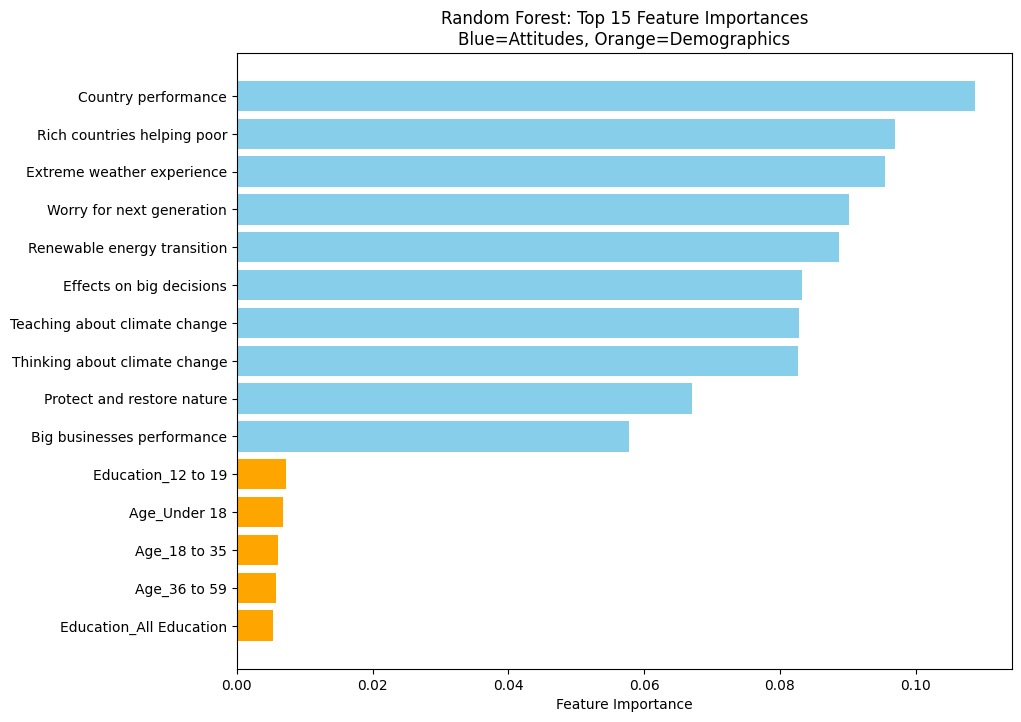

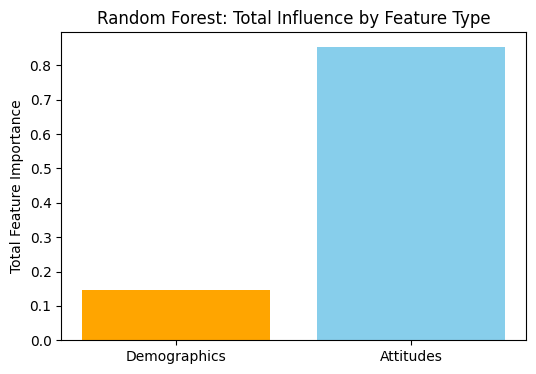

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix,
    roc_auc_score, roc_curve, auc
)

# ==============================
# 1. TARGET QUESTION
# ==============================
# Remove global summary row
df = df[df["Country"] != "Global"].copy()
# Exclude rows with Age = "All Ages" AND Education = "All Education"
df = df[~((df["Age"] == "All Ages") & (df["Education"] == "All Education"))].copy()
target_question = "Should your country strengthen or weaken its commitments to address climate change?"
df_target = df[df["Question Text"] == target_question].copy()
df_target["y"] = (df_target["Weighted Mean"] > 50).astype(int)

df_target = df_target.drop(columns=[
    "Question Text (Short)", "Question Context", "Category", "Cat ID",
    "QID", "RID", "AID", "EID", "ID", "Question Text", "Response"
], errors="ignore")

# ==============================
# 2. SELECT ATTITUDES - FIXED USING CORRECT RESPONSE CATEGORIES
# ==============================

attitude_responses = {
    "Worry for next generation": ["Extremely", "Very","Somewhat"],
    "Extreme weather experience": ["Worse than usual"],
    "Thinking about climate change": ["Daily", "Weekly"],
    "Effects on big decisions": ["A lot"],
    "Renewable energy transition": ["Very quickly", "Somewhat quickly"],
    "Protect and restore nature": ["A lot"],
    "Country performance": ["Very well", "Somewhat well"],
    "Big businesses performance": ["Very well", "Somewhat well"],
    "Teaching about climate change": ["More","More education"],
    "Rich countries helping poor":["More help"]
}

attitude_frames = []

for q_short, positive_responses in attitude_responses.items():
    temp = df[
        (df["Question Text (Short)"] == q_short) &
        (df["Response"].isin(positive_responses))
    ].copy()

    # Sum positive response percentages
    temp = temp.groupby(["Country", "Age", "Education"])["Weighted Mean"].sum().reset_index()
    temp = temp.rename(columns={"Weighted Mean": q_short})

    attitude_frames.append(temp)

# Merge all attitude features
attitudes = attitude_frames[0]
for i in range(1, len(attitude_frames)):
    attitudes = pd.merge(attitudes, attitude_frames[i],
                         on=["Country", "Age", "Education"], how="outer")

# Fill missing (some countries might lack a category)
attitudes = attitudes.fillna(0)

selected_attitudes = list(attitude_responses.keys())

# ==============================
# 3. MERGE TARGET + ATTITUDES
# ==============================
df_model = pd.merge(df_target, attitudes, on=["Country", "Age", "Education"], how="left")

categorical_cols = ["Country", "Age", "Education"]
numeric_cols = selected_attitudes.copy()
X = df_model[categorical_cols + numeric_cols]
y = df_model["y"]

# ==============================
# 4. TRAIN-TEST SPLIT
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==============================
# 5. PREPROCESS PIPELINE
# ==============================
preprocess = ColumnTransformer([
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler())
    ]), numeric_cols)
])

# ==============================
# 6. LOGISTIC REGRESSION
# ==============================
log_reg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500, class_weight='balanced'))
])
log_reg.fit(X_train, y_train)
pred_lr = log_reg.predict(X_test)
prob_lr = log_reg.predict_proba(X_test)[:,1]

# Metrics
acc_lr = accuracy_score(y_test, pred_lr)
f1_lr = f1_score(y_test, pred_lr)
bal_acc_lr = balanced_accuracy_score(y_test, pred_lr)
roc_auc_lr = roc_auc_score(y_test, prob_lr)

print("\n=== Logistic Regression ===")
print("Accuracy:", acc_lr)
print("F1 Score:", f1_lr)
print("Balanced Accuracy:", bal_acc_lr)
print("ROC-AUC:", roc_auc_lr)

# Confusion Matrix
cm_lr = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Coefficients visualization
coefficients = log_reg.named_steps["clf"].coef_[0]
ohe = log_reg.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
ohe_features = ohe.get_feature_names_out(categorical_cols)
final_feature_names = list(ohe_features) + numeric_cols

idx = np.argsort(np.abs(coefficients))[-15:]
top_features = np.array(final_feature_names)[idx]
top_coeffs = coefficients[idx]

colors = []
for f in top_features:
    if f in numeric_cols or any(att in f for att in numeric_cols):
        colors.append("skyblue")  # attitudes
    else:
        if "Country_" in f:
            colors.append("#FFA500")  # orange
        elif "Age_" in f:
            colors.append("#FF8C00")  # dark orange
        elif "Education_" in f:
            colors.append("#FFB347")  # light orange
        else:
            colors.append("grey")

plt.figure(figsize=(10,8))
plt.barh(top_features, top_coeffs, color=colors)
plt.title("Top 15 Logistic Regression Coefficients\nBlue=Attitudes, Shades of Orange=Demographics")
plt.xlabel("Coefficient Value")
plt.show()

# ==============================
# 7. RANDOM FOREST WITH THRESHOLD TUNING
# ==============================
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])
rf.fit(X_train, y_train)
prob_rf = rf.predict_proba(X_test)[:,1]

# Tune threshold for best F1 score
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []

for th in thresholds:
    pred = (prob_rf >= th).astype(int)
    f1_scores.append(f1_score(y_test, pred))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
pred_rf = (prob_rf >= best_threshold).astype(int)
f1_rf = f1_scores[best_idx]

acc_rf = accuracy_score(y_test, pred_rf)
bal_acc_rf = balanced_accuracy_score(y_test, pred_rf)
roc_auc_rf = roc_auc_score(y_test, prob_rf)

print("\n=== Random Forest ===")
print(f"Best Threshold: {best_threshold:.2f}")
print("Accuracy:", acc_rf)
print("F1 Score:", f1_rf)
print("Balanced Accuracy:", bal_acc_rf)
print("ROC-AUC:", roc_auc_rf)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title(f"Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==============================
# 8. ROC CURVES
# ==============================
plt.figure(figsize=(8,6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, prob_rf)

plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression vs Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ==============================
# 9. Predicted Probability Distributions
# ==============================
plt.figure(figsize=(8,6))
sns.histplot(prob_lr[y_test==1], color='blue', label='Strengthen (LR)', kde=True, stat="density")
sns.histplot(prob_lr[y_test==0], color='orange', label='Others (LR)', kde=True, stat="density")
plt.xlabel("Predicted Probability of Strengthen")
plt.title("Logistic Regression: Predicted Probability Distribution")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(prob_rf[y_test==1], color='green', label='Strengthen (RF)', kde=True, stat="density")
sns.histplot(prob_rf[y_test==0], color='red', label='Others (RF)', kde=True, stat="density")
plt.xlabel("Predicted Probability of Strengthen")
plt.title("Random Forest: Predicted Probability Distribution (Threshold Tuned)")
plt.legend()
plt.show()

# ==============================
# 10. Performance Comparison
# ==============================
metrics_dict = {
    "Metric": ["Accuracy", "F1 Score", "Balanced Accuracy", "ROC-AUC"],
    "Logistic Regression": [acc_lr, f1_lr, bal_acc_lr, roc_auc_lr],
    "Random Forest": [acc_rf, f1_rf, bal_acc_rf, roc_auc_rf]
}
perf_df = pd.DataFrame(metrics_dict)
perf_df_melted = perf_df.melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(8,6))
sns.barplot(data=perf_df_melted, x="Metric", y="Score", hue="Model")
plt.ylim(0,1)
plt.title("Model Performance Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==============================
# 11. Random Forest: Top 15 Features + Total Influence
# ==============================
importances = rf.named_steps["clf"].feature_importances_
idx_rf = np.argsort(importances)[-15:]  # top 15 features

# Colors for top features: attitudes = blue, demographics = orange
colors_rf = []
for f in np.array(final_feature_names)[idx_rf]:
    if any(att in f for att in numeric_cols):
        colors_rf.append("skyblue")  # attitude
    else:
        colors_rf.append("orange")   # demographic

plt.figure(figsize=(10,8))
plt.barh(np.array(final_feature_names)[idx_rf], importances[idx_rf], color=colors_rf)
plt.title("Random Forest: Top 15 Feature Importances\nBlue=Attitudes, Orange=Demographics")
plt.xlabel("Feature Importance")
plt.show()

# Total importance by feature type
demographics_idx_rf = [i for i, f in enumerate(final_feature_names) if f not in numeric_cols]
attitudes_idx_rf = [i for i, f in enumerate(final_feature_names) if f in numeric_cols]

demographics_importance_rf = importances[demographics_idx_rf].sum()
attitudes_importance_rf = importances[attitudes_idx_rf].sum()

plt.figure(figsize=(6,4))
plt.bar(["Demographics", "Attitudes"], [demographics_importance_rf, attitudes_importance_rf],
        color=["orange", "skyblue"])
plt.ylabel("Total Feature Importance")
plt.title("Random Forest: Total Influence by Feature Type")
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# 1. Load data
file_path = "Peoples_Climate_Vote_Database_2024.xlsx"
df = pd.read_excel(file_path)

# Keep only the columns we actually use
cols_keep = [
    "Country",
    "Question Text (Short)",
    "Response",
    "Education",
    "Age",
    "Weighted Mean",
]
df = df[cols_keep].copy()

# 2. Restrict to country-level totals:All Ages + All Education
df_country = df[
    (df["Age"] == "All Ages")
    & (df["Education"] == "All Education")
].copy()

# 3. Define which questions and responses we want to turn into features
# Friendly column names for each question
feature_name_map = {
    "Worry for next generation": "worry_nextgen_high",
    "Extreme weather experience": "extreme_weather_worse",
    "Thinking about climate change": "thinking_often",
    "Effects on big decisions": "effects_decisions_alot",
    "Renewable energy transition": "renewables_quick",
    "Protect and restore nature": "protect_nature_alot",
    "Country performance": "country_performance_well",
    "Big businesses performance": "business_performance_well",
    "Teaching about climate change": "teach_climate_more",
    "Rich countries helping poor": "rich_help_poor_more",
}

# For each question, we pick the response categories that
# represent the “pro-climate” / “high concern” end
selected_responses = {
    "Worry for next generation": ["Extremely", "Very", "Somewhat"],
    "Extreme weather experience": ["Worse than usual"],
    "Thinking about climate change": ["Daily", "Weekly"],
    "Effects on big decisions": ["A lot"],
    "Renewable energy transition": ["Very quickly", "Somewhat quickly"],
    "Protect and restore nature": ["A lot"],
    "Country performance": ["Very well", "Somewhat well"],
    "Big businesses performance": ["Very well", "Somewhat well"],
    # Some datasets separate "More" and "More education" – include both just in case
    "Teaching about climate change": ["More", "More education"],
    "Rich countries helping poor": ["More help"],
}

# Build a lookup:
# (Question Text (Short), Response) → feature name
feature_map = {}
for q_text, resp_list in selected_responses.items():
    feature_name = feature_name_map[q_text]
    for resp in resp_list:
        feature_map[(q_text, resp)] = feature_name


def map_feature(row):
    key = (row["Question Text (Short)"], row["Response"])
    return feature_map.get(key, pd.NA)


# Attach a feature name to each row (where applicable)
df_country["feature"] = df_country.apply(map_feature, axis=1)

# Keep only the rows that correspond to one of our selected features
df_feat = df_country.dropna(subset=["feature"]).copy()

# 4. Build a country-level feature table.For each (Country, feature) sum therelevant Weighted Means
country_features = (
    df_feat
    .groupby(["Country", "feature"])["Weighted Mean"]
    .sum()               # e.g. Extremely + Very + Somewhat → worry_nextgen_high
    .unstack("feature")  # columns = features, rows = countries
    .reset_index()
)

# If a country is missing a particular feature, treat it as 0
country_features = country_features.fillna(0.0)

print("Country-level feature table:")
print(country_features.to_string())

# 5. Standardise features for k-means
feature_cols = [c for c in country_features.columns if c != "Country"]
X = country_features[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Try several k values and compute Silhouette and Calinski–Harabasz
print("\nEvaluation for different k:")
sil_scores = {}
ch_scores = {}

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)

    sil_scores[k] = sil
    ch_scores[k] = ch

    print(f"k={k}: silhouette={sil:.3f}, Calinski-Harabasz={ch:.1f}")

# Use the best silhouette score to pick k
k_opt = max(sil_scores, key=sil_scores.get)

print(
    f"\nOptimal k (by silhouette): k={k_opt}, "
    f"silhouette={sil_scores[k_opt]:.3f}, "
    f"CH={ch_scores[k_opt]:.1f}"
)

# 7. Fit final k-means model with k_opt and assign each country to a cluster
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
country_features["Cluster"] = kmeans.fit_predict(X_scaled)

print("\nCountry-level feature table with cluster labels:")
print(country_features.to_string())

print("\nNumber of countries in each cluster:")
print(country_features["Cluster"].value_counts().sort_index())

# 8. Cluster-wise averages to interpret what each cluster “means”
cluster_means = country_features.groupby("Cluster")[feature_cols].mean()
print("\nCluster-wise mean features:")
print(cluster_means.to_string())


Country-level feature table:
feature                                                     Country  business_performance_well  country_performance_well  effects_decisions_alot  extreme_weather_worse  protect_nature_alot  renewables_quick  rich_help_poor_more  teach_climate_more  thinking_often  worry_nextgen_high
0                                                       Afghanistan                       48.0                      42.0                    73.0                   52.0                 91.0              48.0                 97.0                91.0            84.0                90.0
1                                                           Algeria                       13.0                      22.0                    47.0                   74.0                 95.0              70.0                 90.0                95.0            75.0                71.0
2                                                         Argentina                       15.0                      16.